In [5]:
#LSTM 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
df = pd.read_csv('BABA.csv')

# Select features
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close']

# Split the dataset into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Prepare the dataset for LSTM
def create_dataset(data, look_back=1, output_col=-1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), :output_col] # Exclude the output column from inputs
        X.append(a)
        Y.append(data[i + look_back, output_col]) # Only use the output column as Y
    return np.array(X), np.array(Y)

look_back = 5
output_col_index = features.index('Close') # Assuming 'Close' is the output column
X_train, Y_train = create_dataset(train_scaled, look_back, output_col_index)
X_test, Y_test = create_dataset(test_scaled, look_back, output_col_index)

# Reshape input for LSTM [samples, time steps, features]
num_features = len(features) - 1 # Exclude the output column from the count
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 5)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=1, batch_size=1)

# Predicting
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Evaluation
train_mae = mean_absolute_error(Y_train, train_predict)
test_mae = mean_absolute_error(Y_test, test_predict)
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))

print('LSTM - Train MAE:', train_mae, 'Train RMSE:', train_rmse)
print('LSTM - Test MAE:', test_mae, 'Test RMSE:', test_rmse)

14/14 [==============================] - 0s 3ms/step
LSTM - Train MAE: 0.015804319262790363 Train RMSE: 0.022341761405921368
LSTM - Test MAE: 0.017918198194904374 Test RMSE: 0.023647856831923292


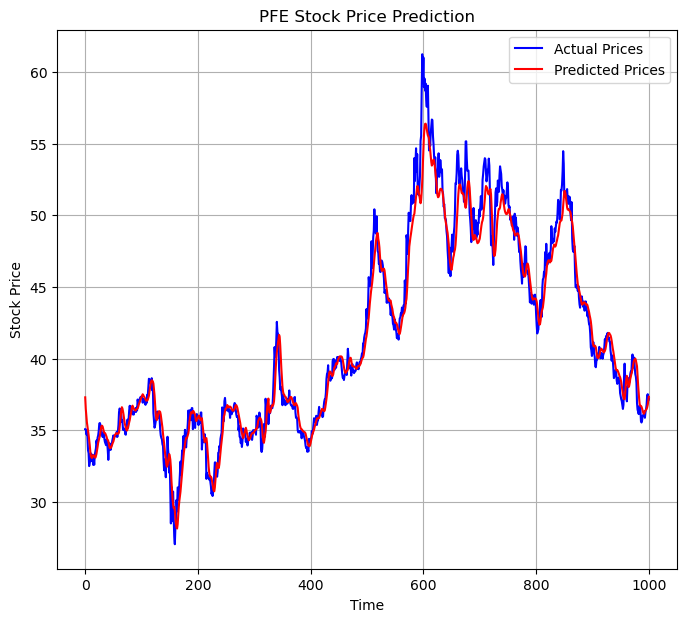

In [31]:
import matplotlib.pyplot as plt

# Function to reconstruct the full feature set for inverse transformation
def reconstruct_features(original_data, target_data, target_index):
    reconstructed_data = np.copy(original_data)
    reconstructed_data[:, target_index] = target_data
    return reconstructed_data

# Adjusting the size of test_scaled to match the number of predictions
test_scaled_adjusted = test_scaled[look_back:len(test_predict) + look_back]

# Reconstruct the full feature set with predicted and actual 'Close' values
predicted_full_set = reconstruct_features(test_scaled_adjusted, test_predict[:, 0], output_col_index)
actual_full_set = reconstruct_features(test_scaled_adjusted, Y_test, output_col_index)

# Inverse transforming the predictions and actual values
predicted_test_unscaled = scaler.inverse_transform(predicted_full_set)[:, output_col_index]
actual_test_unscaled = scaler.inverse_transform(actual_full_set)[:, output_col_index]

# Plotting the results for the test set
plt.figure(figsize=(8, 7))
plt.plot(actual_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predicted_test_unscaled, label='Predicted Prices', color='red')
plt.title('PFE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('PFE4.png', dpi=600)
plt.show()

In [38]:
#CNN
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Load the dataset
df = pd.read_csv('NVS.csv')

# Select features
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close']

# Prepare the dataset for CNN
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0:-1])
        Y.append(data[i + look_back, -1])
    return np.array(X), np.array(Y)

look_back = 5

# Split into train and test sets before scaling
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

# Normalize the features - Fit the scaler on training data only
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])  # Apply the same transformation to the test set

# Create datasets for training and testing
X_train, Y_train = create_dataset(train_scaled, look_back)
X_test, Y_test = create_dataset(test_scaled, look_back)

# Reshape input for CNN [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 5)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Predicting
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Evaluation (scaled results)
train_mae_scaled = mean_absolute_error(Y_train, train_predict)
test_mae_scaled = mean_absolute_error(Y_test, test_predict)
train_rmse_scaled = np.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse_scaled = np.sqrt(mean_squared_error(Y_test, test_predict))

print('Scaled Test MAE:', test_mae_scaled)
print('Scaled Test RMSE:', test_rmse_scaled)

32/32 [==============================] - 0s 2ms/step
Scaled Test MAE: 0.019295016664802538
Scaled Test RMSE: 0.026721101230733263


In [4]:
#CNN-LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten


# Load the dataset
df = pd.read_csv('BABA.csv')

# Select features
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close']

# Split the dataset into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Continue with scaling and data preparation
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Assuming create_dataset function as defined in your code
look_back = 5
output_col_index = features.index('Close') # Assuming 'Close' is the output column
X_train, Y_train = create_dataset(train_scaled, look_back, output_col_index)
X_test, Y_test = create_dataset(test_scaled, look_back, output_col_index)

# Update reshape input for LSTM to include the CNN layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

# Assuming the rest of the code is unchanged
model = Sequential()
# Convolutional layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, num_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# It's more typical to transition to dense layers after flattening in this context
model.add(Dense(50, activation='relu'))  # Replace the LSTM layers with dense layers after flattening
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile and train the model as before
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=1, batch_size=1)

# Predicting and Evaluation as before
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_mae = mean_absolute_error(Y_train, train_predict)
test_mae = mean_absolute_error(Y_test, test_predict)
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))

print('CNN-LSTM - Train MAE:', train_mae, 'Train RMSE:', train_rmse)
print('CNN-LSTM - Test MAE:', test_mae, 'Test RMSE:', test_rmse)

14/14 [==============================] - 0s 2ms/step
CNN-LSTM - Train MAE: 0.019140293189803655 Train RMSE: 0.026493216642277002
CNN-LSTM - Test MAE: 0.017898738560493545 Test RMSE: 0.02396206971731535


In [44]:
#SVR
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('NVS.csv')

# Select features
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

# Prepare the dataset for SVR
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :-1])  # Include all features except 'Close'
        Y.append(data[i + look_back, -1])  # Predict the 'Close' value
    return np.array(X), np.array(Y)

look_back = 5

# Split into train and test sets before scaling to avoid data leakage
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Normalize the features - Fit the scaler on training data only
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])  # Apply the same transformation to the test set

# Create datasets for training and testing
# Make sure to transform the 'Close' column separately to avoid using future data
train_features, train_target = create_dataset(train_scaled, look_back)
test_features, test_target = create_dataset(test_scaled, look_back)

# Flatten train_features and test_features for SVR
train_features_flatten = train_features.reshape(train_features.shape[0], -1)
test_features_flatten = test_features.reshape(test_features.shape[0], -1)

# Build the SVR model
svr_model = SVR(kernel='rbf')

# Train the model
svr_model.fit(train_features_flatten, train_target)

# Predicting
train_predict = svr_model.predict(train_features_flatten)
test_predict = svr_model.predict(test_features_flatten)

# Evaluation (scaled results)
train_mae = mean_absolute_error(train_target, train_predict)
test_mae = mean_absolute_error(test_target, test_predict)
train_rmse = np.sqrt(mean_squared_error(train_target, train_predict))
test_rmse = np.sqrt(mean_squared_error(test_target, test_predict))

print('Test MAE:', test_mae)
print('Test RMSE:', test_rmse)

Test MAE: 0.06683883229765084
Test RMSE: 0.07013258576992334


In [58]:
#RNN
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn

# Load the dataset
df = pd.read_csv('NVS.csv')

# Select features
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

# Prepare the dataset for RNN
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :-1])
        Y.append(data[i + look_back, -1])
    return np.array(X), np.array(Y)

look_back = 5

# Split into train and test sets before scaling to avoid data leakage
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Normalize the features - Fit the scaler on training data only
scaler_features = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler_features.fit_transform(train[features])
test_scaled = scaler_features.transform(test[features])  # Apply the same transformation to the test set

scaler_target = MinMaxScaler(feature_range=(0, 1))
train_target_scaled = scaler_target.fit_transform(train[['Close']])
test_target_scaled = scaler_target.transform(test[['Close']])

# Create datasets for training and testing
train_features, train_target = create_dataset(train_scaled, look_back)
test_features, test_target = create_dataset(test_scaled, look_back)

# Convert datasets to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_target_tensor = torch.tensor(train_target, dtype=torch.float32).view(-1, 1)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_target_tensor = torch.tensor(test_target, dtype=torch.float32).view(-1, 1)

# RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        return x

# Model parameters
input_size = len(features) - 1  # Minus 'Close' feature
hidden_size = 10
num_layers = 2
output_size = 1

# Instantiate the model
rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    rnn_model.train()
    optimizer.zero_grad()
    output = rnn_model(train_features_tensor)
    loss = criterion(output, train_target_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
rnn_model.eval()
train_predict_tensor = rnn_model(train_features_tensor)
test_predict_tensor = rnn_model(test_features_tensor)

# Scaled Evaluation
train_mae_scaled = mean_absolute_error(train_target_tensor.detach().numpy(), train_predict_tensor.detach().numpy())
test_mae_scaled = mean_absolute_error(test_target_tensor.detach().numpy(), test_predict_tensor.detach().numpy())
train_rmse_scaled = np.sqrt(mean_squared_error(train_target_tensor.detach().numpy(), train_predict_tensor.detach().numpy()))
test_rmse_scaled = np.sqrt(mean_squared_error(test_target_tensor.detach().numpy(), test_predict_tensor.detach().numpy()))

print('Scaled Test MAE:', test_mae_scaled)
print('Scaled Test RMSE:', test_rmse_scaled)

Epoch [0/100], Loss: 0.1253
Epoch [10/100], Loss: 0.0392
Epoch [20/100], Loss: 0.0064
Epoch [30/100], Loss: 0.0036
Epoch [40/100], Loss: 0.0041
Epoch [50/100], Loss: 0.0028
Epoch [60/100], Loss: 0.0025
Epoch [70/100], Loss: 0.0025
Epoch [80/100], Loss: 0.0023
Epoch [90/100], Loss: 0.0022
Scaled Test MAE: 0.03508087
Scaled Test RMSE: 0.03866639


In [57]:
#Lightweight Transformer 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the data
data = pd.read_csv('NVS.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

# Normalize the Close prices
scaler = MinMaxScaler(feature_range=(-1, 1))
price_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1)).flatten()

# Variable to control the number of future steps to predict
steps = 1

# Data Preprocessing Function modified for multi-step
def create_sequences(data, sequence_length, steps):
    xs, ys = [], []
    for i in range(len(data) - sequence_length - steps + 1):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length:i + sequence_length + steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences with modified function
sequence_length = 1  # Updated sequence length
X, y = create_sequences(price_data, sequence_length, steps)

# Split the data
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors, adjusted for multi-step
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader instances, adjusted for multi-step
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the PositionalEncoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Define the TransformerModel class
class TransformerModel(nn.Module):
    def __init__(self, n_features, d_model, n_heads, n_hidden, n_layers, dropout):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, n_hidden, dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, n_layers)
        self.decoder = nn.Linear(d_model, n_features)
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = x.unsqueeze(-1).transpose(0, 1)  # Add a feature dimension and transpose
        if self.src_mask is None or self.src_mask.size(0) != len(x):
            mask = self._generate_square_subsequent_mask(len(x)).to(x.device)
            self.src_mask = mask
        x = self.pos_encoder(x)
        output = self.transformer_encoder(x, self.src_mask)
        output = self.decoder(output)
        return output[-steps:]

# Instantiate the model, adjusted for multi-step
n_features = steps  # Adjust the output features for multi-step
model = TransformerModel(n_features=n_features, d_model=128, n_heads=8, n_hidden=512, n_layers=4, dropout=0.1)

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss Function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Scheduler - OneCycleLR
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
# Training function
def train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, epochs, patience):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    train_losses = []
    valid_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            sequences, labels = batch
            sequences, labels = sequences.to(device), labels.to(device)
            predictions = model(sequences).squeeze(0)  # Adjusting the model's output shape here as well
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        avg_valid_loss = evaluate(model, test_loader, criterion)
        valid_losses.append(avg_valid_loss)
        
        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')
        
        early_stopping(avg_valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, valid_losses

# Define the evaluate function before train_model is called
def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            sequences, labels = batch
            sequences, labels = sequences.to(device), labels.to(device)
            predictions = model(sequences).squeeze(0)  # Ensure this matches the expected dimensions
            loss = criterion(predictions, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Run the training loop
train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, epochs=50, patience=5)

# After the training loop
train_losses, valid_losses = train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, epochs=50, patience=5)

# Load best model, adjusted for multi-step
best_model = TransformerModel(n_features=n_features, d_model=128, n_heads=8, n_hidden=512, n_layers=4, dropout=0.1)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

# Evaluate on test data, adjusted for multi-step
test_loss = evaluate(best_model, test_loader, criterion)
print(f'Test Loss: {test_loss}')

# Calculate and print additional metrics, adjusted for multi-step
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        sequences, labels = batch
        sequences, labels = sequences.to(device), labels.to(device)
        predictions = best_model(sequences)
        # Adjust shape for multi-step predictions
        y_pred.extend(predictions.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

# Convert predictions and true values to arrays
y_pred = np.array(y_pred).reshape(-1, steps)
y_true = np.array(y_true).reshape(-1, steps)

# Calculate MAE and RMSE for each step and then average (if multi-step)
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
print(f'MAE: {np.mean(mae)}')
print(f'RMSE: {np.mean(rmse)}')

Epoch 1: Training Loss: 0.14025106682429012, Validation Loss: 0.04074137844145298
Validation loss decreased (inf --> 0.040741).  Saving model ...
Epoch 2: Training Loss: 0.01344637273036888, Validation Loss: 0.007352922824793495
Validation loss decreased (0.040741 --> 0.007353).  Saving model ...
Epoch 3: Training Loss: 0.009204597297636136, Validation Loss: 0.003541747559211217
Validation loss decreased (0.007353 --> 0.003542).  Saving model ...
Epoch 4: Training Loss: 0.008105392823599174, Validation Loss: 0.006085603323299438
EarlyStopping counter: 1 out of 5
Epoch 5: Training Loss: 0.00610827714611422, Validation Loss: 0.018686740135308355
EarlyStopping counter: 2 out of 5
Epoch 6: Training Loss: 0.00673653466404009, Validation Loss: 0.010999381076544523
EarlyStopping counter: 3 out of 5
Epoch 7: Training Loss: 0.0059100296249954215, Validation Loss: 0.015870327246375382
EarlyStopping counter: 4 out of 5
Epoch 8: Training Loss: 0.007155740758220495, Validation Loss: 0.0338470119895

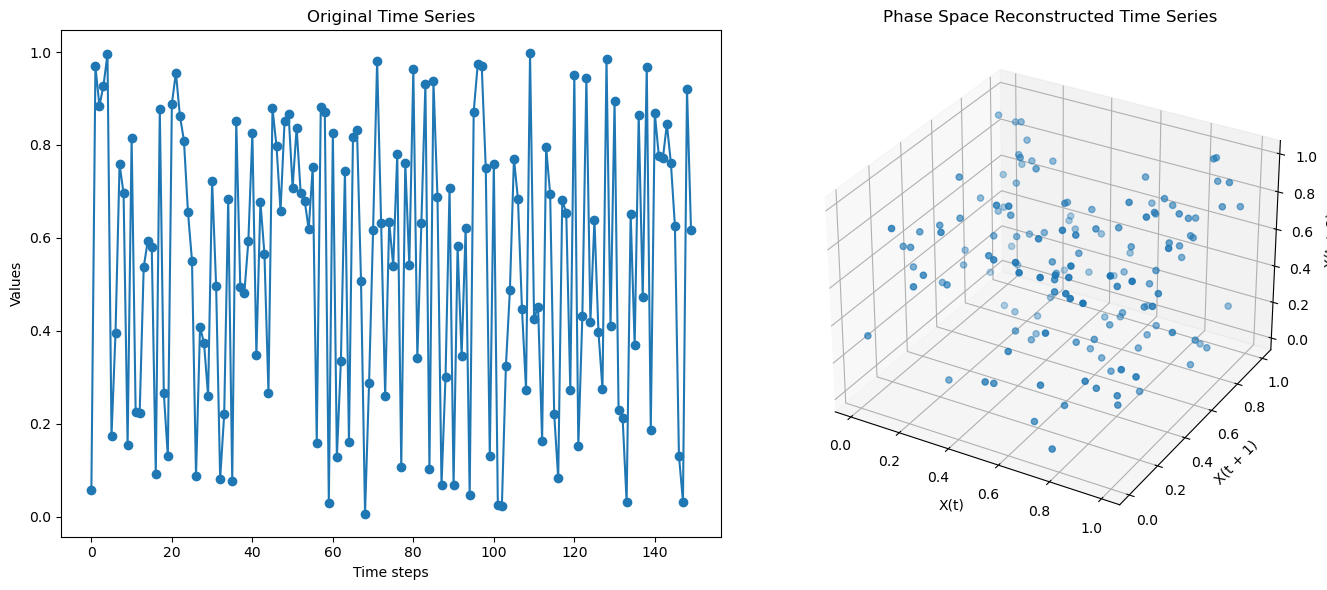

In [68]:
#Example for the Applied Phase Space Reconstruction 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example time series data
time_series = np.random.rand(150)  # Replace with your actual time series data

# Phase space reconstruction with delay of 1 and embedding dimension of 3
delay = 1
embedding_dim = 3
reconstructed = np.array([time_series[i:i+embedding_dim] for i in range(len(time_series) - embedding_dim + 1)])

# Plotting the original time series
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(time_series, 'o-')
plt.title('Original Time Series')
plt.xlabel('Time steps')
plt.ylabel('Values')

# Plotting the phase space reconstruction
ax = plt.subplot(1, 2, 2, projection='3d')
ax.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2])
ax.set_title('Phase Space Reconstructed Time Series')
ax.set_xlabel('X(t)')
ax.set_ylabel('X(t + 1)')
ax.set_zlabel('X(t + 2)')

# Show the plots
plt.tight_layout()
plt.savefig('PSR2.png', dpi=1000)
plt.show()
